In [45]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay,roc_auc_score,accuracy_score,RocCurveDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve, CalibrationDisplay
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.inspection import permutation_importance


## Joining Relevant Datasets and Data Cleaning 

In [46]:
inflation_df = pd.read_csv("potentialDataSetsHW2/us_inflation.csv")
interest_df = pd.read_csv("potentialDataSetsHW2/us_interest_rates.csv")
gdp_df = pd.read_csv("potentialDataSetsHW2/usa_gdp.csv")

inflation_df = inflation_df.dropna()
# have an "ave" (average) row per year with NaN values, so we dropped it
interest_df = interest_df.dropna()
gdp_df = gdp_df.iloc[:,1:].dropna()

gdp_df.head()
gdp_df = gdp_df.rename(columns={"date":"year"})

In [47]:
gdp_df.head()

,year,gdp,gdp_cap
0,1960,5.419886e+11,2999.864872
1,1961,5.619403e+11,3059.160821
2,1962,6.036394e+11,3236.013112
3,1963,6.370586e+11,3366.369790
4,1964,6.841446e+11,3565.314430


In [48]:
inflation_df['month_num'] = inflation_df['month_num'].astype(int)
inflation_df['date'] = inflation_df['year'].astype(str) + inflation_df['month_num'].apply(lambda x: f'{x:02d}')
inflation_df['date'] = inflation_df['date'].astype(str)
inflation_df.head()

,year,months,month_num,inflat_rate,date
0,1914,Jan,1,2.0,191401
1,1914,Feb,2,1.0,191402
2,1914,Mar,3,1.0,191403
3,1914,Apr,4,0.0,191404
4,1914,May,5,2.1,191405


In [119]:
interest_df['observation_date'] = pd.to_datetime(interest_df['observation_date'])
interest_df['date'] = interest_df['observation_date'].dt.strftime('%Y%m').astype(str)
interest_df.head()

,observation_date,months,month_num,interest_rate,date
0,1954-07-01 00:00:00+00:00,Jul,7,0.80,195407
1,1954-08-01 00:00:00+00:00,Aug,8,1.22,195408
2,1954-09-01 00:00:00+00:00,Sep,9,1.07,195409
3,1954-10-01 00:00:00+00:00,Oct,10,0.85,195410
4,1954-11-01 00:00:00+00:00,Nov,11,0.83,195411


Reducing the Credit Survey data to the columns that were relevant based on literature review.

In [50]:
credit_df = pd.read_excel("potentialDataSetsHW2/sce_credit.xlsx", sheet_name="Data")
reduced_credit_df = credit_df[["userid", "date", "weight", 
                               "N1_1", "N1_2", "N1_3", 
                               "N1_4","N1_5","N1_6",
                               "N2_1","N2_2", "N2_3",
                               "N2_4", "N2_5", "N2_6",
                               "N3", "N4_4", "N4_5", "N4_6",
                               "N10_1", "N10_2", "N10_3",
                               "N10_4", "N10_5", "N10_7",
                               "N15", "N16",
                               "N22", "N23", "N25"]]
reduced_credit_df


,userid,date,weight,N1_1,N1_2,N1_3,N1_4,N1_5,N1_6,N2_1,...,N10_2,N10_3,N10_4,N10_5,N10_7,N15,N16,N22,N23,N25
0,70000337,201310,5.382000,0,0,1,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
1,70000341,201310,0.557000,1,1,1,0,1,0,20000.0,...,NaN,15000.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2,70003202,201310,0.868000,0,1,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
3,70003205,201310,0.422000,1,1,0,0,0,0,70000.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
4,70003238,201310,0.638000,0,1,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34357,75017565,202402,0.741707,1,1,1,1,1,0,250.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,4.0,4.0,93.0
34358,75017580,202402,1.262060,1,1,0,0,0,0,8000.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,5.0,1.0,100.0
34359,75017584,202402,1.467306,1,0,1,0,1,0,10000.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,1.0,0.0
34360,75017586,202402,0.545003,1,1,1,0,0,0,19000.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,2.0,5.0,100.0


In [51]:
reduced_credit_df.loc[:,'date'] = reduced_credit_df['date'].astype(str)
gdp_df.loc[:,'year'] = gdp_df['year'].astype(str)
reduced_credit_df.loc[:,'year'] = reduced_credit_df['date'].astype(str).str[:4]

/var/folders/zg/ls8bd3c56117c99w5bccvcjw0000gn/T/ipykernel_77837/794276196.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_credit_df.loc[:,'year'] = reduced_credit_df['date'].astype(str).str[:4]


In [52]:
df_merged = reduced_credit_df.merge(inflation_df[['date', 'inflat_rate']], on='date', how='left')
df_merged = df_merged.merge(interest_df[['date', 'interest_rate']], on='date', how='left')
df_final = df_merged.merge(gdp_df, on='year', how='left')
df_final.head()

,userid,date,weight,N1_1,N1_2,N1_3,N1_4,N1_5,N1_6,N2_1,...,N15,N16,N22,N23,N25,year,inflat_rate,interest_rate,gdp,gdp_cap
0,70000337,201310,5.382,0,0,1,0,0,0,NaN,...,1.0,NaN,NaN,NaN,NaN,2013,1.0,0.09,1.688068e+13,53409.750777
1,70000341,201310,0.557,1,1,1,0,1,0,20000.0,...,0.0,NaN,NaN,NaN,NaN,2013,1.0,0.09,1.688068e+13,53409.750777
2,70003202,201310,0.868,0,1,0,0,0,0,NaN,...,0.0,NaN,NaN,NaN,NaN,2013,1.0,0.09,1.688068e+13,53409.750777
3,70003205,201310,0.422,1,1,0,0,0,0,70000.0,...,0.0,NaN,NaN,NaN,NaN,2013,1.0,0.09,1.688068e+13,53409.750777
4,70003238,201310,0.638,0,1,0,0,0,0,NaN,...,0.0,NaN,NaN,NaN,NaN,2013,1.0,0.09,1.688068e+13,53409.750777


In [53]:
# if don't own a type of loan, their balance would be NaN, filling in with 0
df_final.loc[df_final['N1_1'] == 0, 'N2_1'] = 0
df_final.loc[df_final['N1_2'] == 0, 'N2_2'] = 0
df_final.loc[df_final['N1_3'] == 0, 'N2_3'] = 0
df_final.loc[df_final['N1_4'] == 0, 'N2_4'] = 0
df_final.loc[df_final['N1_5'] == 0, 'N2_5'] = 0
df_final.loc[df_final['N1_6'] == 0, 'N2_6'] = 0
# if not late by 30 days then not 90 days late
df_final.loc[df_final['N15'] == 0, 'N16'] = 0

Omit amount lended by loaner and request to increase loan due to lack of data– more than one third of those values were NaNs.

In [54]:
df_final = df_final.drop(columns=["N4_4", "N4_5", "N4_6",
                               "N10_1", "N10_2", "N10_3",
                               "N10_4", "N10_5", "N10_7"])
# df_final.isna().sum()

In [55]:
print (f"""Shape before cleaning {df_final.shape}""")
df_final_cleaned = df_final.dropna()
print (f"""Shape after cleaning {df_final_cleaned.shape}""")
df_final_cleaned

Shape before cleaning (34362, 26)
Shape after cleaning (18797, 26)


,userid,date,weight,N1_1,N1_2,N1_3,N1_4,N1_5,N1_6,N2_1,...,N15,N16,N22,N23,N25,year,inflat_rate,interest_rate,gdp,gdp_cap
7004,70051996,201510,1.048000,1,0,0,0,0,0,0.0,...,0.0,0.0,4.0,5.0,100.0,2015,0.2,0.12,1.829502e+13,57040.208214
7005,70052003,201510,0.491000,1,1,1,0,1,0,2000.0,...,0.0,0.0,5.0,4.0,100.0,2015,0.2,0.12,1.829502e+13,57040.208214
7006,70052014,201510,0.577000,1,0,0,1,0,0,0.0,...,0.0,0.0,4.0,5.0,100.0,2015,0.2,0.12,1.829502e+13,57040.208214
7008,70052043,201510,1.087000,1,0,1,0,1,0,311.0,...,0.0,0.0,1.0,3.0,10.0,2015,0.2,0.12,1.829502e+13,57040.208214
7010,70052292,201510,0.784000,1,1,0,0,0,0,1500.0,...,0.0,0.0,5.0,1.0,100.0,2015,0.2,0.12,1.829502e+13,57040.208214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33375,75015207,202310,0.949974,1,0,0,0,0,1,3000.0,...,0.0,0.0,5.0,1.0,100.0,2023,3.2,5.33,2.772071e+13,82769.412211
33376,75015209,202310,0.462812,1,1,1,1,1,0,5000.0,...,0.0,0.0,5.0,2.0,90.0,2023,3.2,5.33,2.772071e+13,82769.412211
33377,75015213,202310,0.936813,1,1,0,0,1,0,1000.0,...,0.0,0.0,5.0,2.0,0.0,2023,3.2,5.33,2.772071e+13,82769.412211
33379,75015225,202310,1.370018,1,0,0,0,1,0,3000.0,...,1.0,0.0,2.0,3.0,50.0,2023,3.2,5.33,2.772071e+13,82769.412211


In [56]:
df_final_cleaned.rename(columns={"N1_1":"HaveCredit", "N1_2":"HaveMortgage",
                                 "N1_3":"HaveStudent", "N1_4":"HaveHomeBasedLoan",
                                 "N1_5":"HaveAuto", "N1_6":"Other", "N1_7":"None",
                                 "N2_1":"CreditBal", "N2_2":"MortgageBal",
                                 "N2_3":"StudentBal", "N2_4":"HomeBasedBal",
                                 "N2_5":"AutoBal", "N2_6":"OtherBal",
                                 "N3":"MaxedCredit",
                                 "N15":"Late30Days", "N16":"Late90Days",
                                 "N22":"CreditScore", "N23":"LastCheckCredit",
                                 "N25":"LikAble2k"}, inplace=True)

/var/folders/zg/ls8bd3c56117c99w5bccvcjw0000gn/T/ipykernel_77837/2633406663.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_cleaned.rename(columns={"N1_1":"HaveCredit", "N1_2":"HaveMortgage",


In [57]:
df_final_cleaned.head()

,userid,date,weight,HaveCredit,HaveMortgage,HaveStudent,HaveHomeBasedLoan,HaveAuto,Other,CreditBal,...,Late30Days,Late90Days,CreditScore,LastCheckCredit,LikAble2k,year,inflat_rate,interest_rate,gdp,gdp_cap
7004,70051996,201510,1.048,1,0,0,0,0,0,0.0,...,0.0,0.0,4.0,5.0,100.0,2015,0.2,0.12,1.829502e+13,57040.208214
7005,70052003,201510,0.491,1,1,1,0,1,0,2000.0,...,0.0,0.0,5.0,4.0,100.0,2015,0.2,0.12,1.829502e+13,57040.208214
7006,70052014,201510,0.577,1,0,0,1,0,0,0.0,...,0.0,0.0,4.0,5.0,100.0,2015,0.2,0.12,1.829502e+13,57040.208214
7008,70052043,201510,1.087,1,0,1,0,1,0,311.0,...,0.0,0.0,1.0,3.0,10.0,2015,0.2,0.12,1.829502e+13,57040.208214
7010,70052292,201510,0.784,1,1,0,0,0,0,1500.0,...,0.0,0.0,5.0,1.0,100.0,2015,0.2,0.12,1.829502e+13,57040.208214


## Data Exploration

Text(0.5, 1.0, 'Interest Rate')

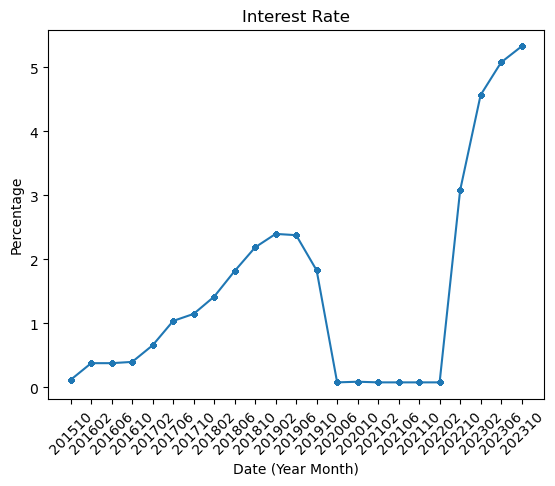

In [58]:
plt.plot(df_final_cleaned["date"], df_final_cleaned["interest_rate"], ".-")
plt.xticks(rotation=45)
plt.xlabel("Date (Year Month)")
plt.ylabel("Percentage")
plt.title("Interest Rate")

Text(0.5, 1.0, 'Inflation Rate')

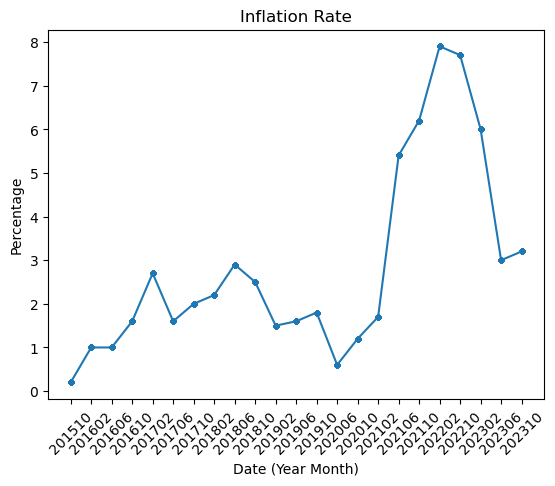

In [59]:
plt.plot(df_final_cleaned["date"], df_final_cleaned["inflat_rate"], ".-")
plt.xticks(rotation=45)
plt.xlabel("Date (Year Month)")
plt.ylabel("Percentage")
plt.title("Inflation Rate")

In [60]:
groupbydate = df_final_cleaned.groupby("date")["Late90Days"].count()
groupbydate.name = "CntLatePayment"
groupbydate = groupbydate.reset_index()

Text(0.5, 1.0, 'Late Payments Over Time')

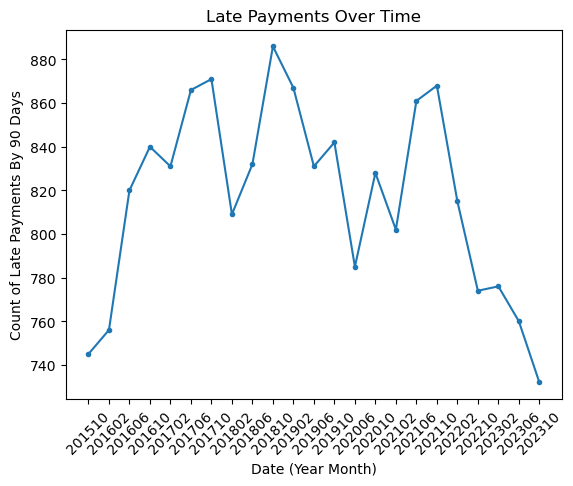

In [61]:
plt.plot(groupbydate["date"], groupbydate["CntLatePayment"], ".-")
plt.xticks(rotation=45)
plt.xlabel("Date (Year Month)")
plt.ylabel("Count of Late Payments By 90 Days")
plt.title("Late Payments Over Time")

/var/folders/zg/ls8bd3c56117c99w5bccvcjw0000gn/T/ipykernel_77837/3377788971.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_cleaned["loan_count"] = (df_final_cleaned["HaveCredit"] + df_final_cleaned["HaveMortgage"] + df_final_cleaned["HaveStudent"] +


Text(0, 0.5, 'Frequency')

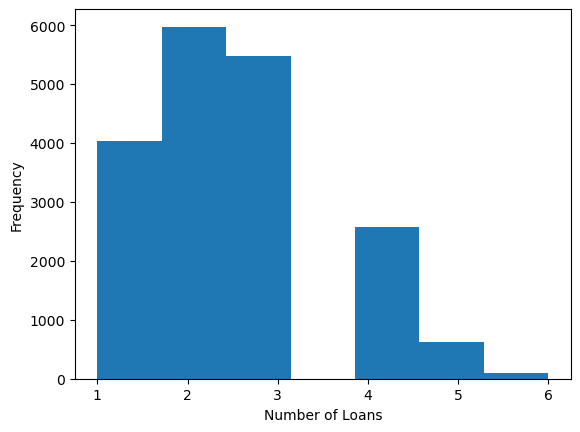

In [62]:
df_final_cleaned["loan_count"] = (df_final_cleaned["HaveCredit"] + df_final_cleaned["HaveMortgage"] + df_final_cleaned["HaveStudent"] + 
                          df_final_cleaned["HaveHomeBasedLoan"] + df_final_cleaned["HaveAuto"] + df_final_cleaned["Other"])

plt.hist(df_final_cleaned["loan_count"], bins = 7)
plt.xlabel("Number of Loans")
plt.ylabel("Frequency")

In [63]:
df_final_cleaned["Late90Days"].value_counts()

Late90Days
0.0    18301
1.0      496
Name: count, dtype: int64

In [64]:
df_final_cleaned.loc[:,"loan_count(w/outCredit)"] = (df_final_cleaned["HaveMortgage"] + df_final_cleaned["HaveStudent"] + 
                          df_final_cleaned["HaveHomeBasedLoan"] + df_final_cleaned["HaveAuto"] + df_final_cleaned["Other"])

/var/folders/zg/ls8bd3c56117c99w5bccvcjw0000gn/T/ipykernel_77837/1148109277.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_cleaned.loc[:,"loan_count(w/outCredit)"] = (df_final_cleaned["HaveMortgage"] + df_final_cleaned["HaveStudent"] +


In [128]:
df_final_cleaned.columns

Index(['userid', 'date', 'weight', 'HaveCredit', 'HaveMortgage', 'HaveStudent',
       'HaveHomeBasedLoan', 'HaveAuto', 'Other', 'CreditBal', 'MortgageBal',
       'StudentBal', 'HomeBasedBal', 'AutoBal', 'OtherBal', 'MaxedCredit',
       'Late30Days', 'Late90Days', 'CreditScore', 'LastCheckCredit',
       'LikAble2k', 'year', 'inflat_rate', 'interest_rate', 'gdp', 'gdp_cap',
       'loan_count', 'loan_count(w/outCredit)', 'TotalBal'],
      dtype='object')

In [134]:
print (f"The average credit card balance is {df_final_cleaned['CreditBal'].mean()}")
print (f"The average mortgage balance is {df_final_cleaned['MortgageBal'].mean()}")
print (f"The average student loan balance is {df_final_cleaned['StudentBal'].mean()}")
print (f"The average home based loan balance is {df_final_cleaned['HomeBasedBal'].mean()}")
print (f"The average auto loan balance is {df_final_cleaned['AutoBal'].mean()}")

The average credit card balance is 8379.086822360807
The average mortgage balance is 93631.39299525725
The average student loan balance is 11228.581730025902
The average home based loan balance is 3687.5446938008727
The average auto loan balance is 8678.93367926481


In [65]:
df_final_cleaned["loan_count"].describe()

count    18797.000000
mean         2.473373
std          1.103495
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: loan_count, dtype: float64

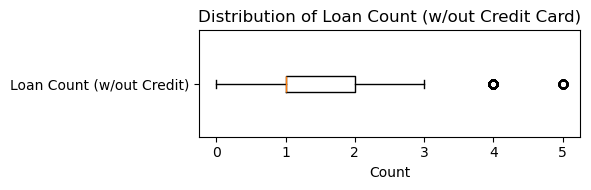

In [66]:
plt.figure(figsize=(6, 2))
plt.boxplot(df_final_cleaned["loan_count(w/outCredit)"], vert=False)
plt.yticks([1], ["Loan Count (w/out Credit)"])
plt.xlabel("Count")
plt.title("Distribution of Loan Count (w/out Credit Card)")
plt.tight_layout()


In [67]:
high_num_loans = df_final_cleaned[(df_final_cleaned["loan_count"]>=
                                   df_final_cleaned["loan_count"].quantile(0.8))]
high_num_loans["Late30Days"].value_counts()

Late30Days
0.0    8103
1.0     688
Name: count, dtype: int64

In [68]:
high_num_loans["Late90Days"].value_counts()

Late90Days
0.0    8506
1.0     285
Name: count, dtype: int64

In [69]:
low_num_loans = df_final_cleaned[(df_final_cleaned["loan_count"]<=df_final_cleaned["loan_count"].quantile(0.2))]
low_num_loans["Late30Days"].value_counts()

Late30Days
0.0    3929
1.0     104
Name: count, dtype: int64

In [70]:
low_num_loans["Late90Days"].value_counts()

Late90Days
0.0    3983
1.0      50
Name: count, dtype: int64

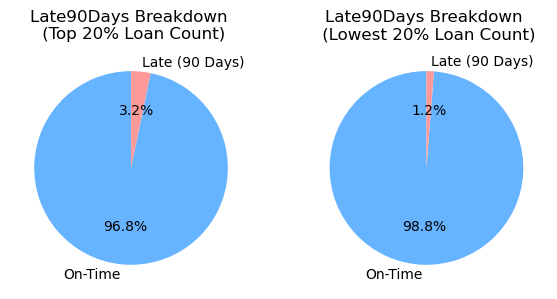

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
high_num_loans["Late90Days"].value_counts().sort_index().plot(
    kind='pie',
    labels=["On-Time", "Late (90 Days)"],
    autopct='%1.1f%%',
    startangle=90,
    colors=["#66b3ff", "#ff9999"],
    ax=axes[0]
)
axes[0].set_ylabel("")
axes[0].set_title("Late90Days Breakdown \n (Top 20% Loan Count)")

# Low loan count pie chart
low_num_loans["Late90Days"].value_counts().sort_index().plot(
    kind='pie',
    labels=["On-Time", "Late (90 Days)"],
    autopct='%1.1f%%',
    startangle=90,
    colors=["#66b3ff", "#ff9999"],
    ax=axes[1]
)
axes[1].set_ylabel("")
axes[1].set_title("Late90Days Breakdown \n (Lowest 20% Loan Count)")

plt.tight_layout()
plt.show()

In [72]:
inflat_grouped = df_final_cleaned.groupby("inflat_rate")["Late90Days"].mean()
inflat_grouped.name = "Delinquency Rate"
inflat_grouped = inflat_grouped.reset_index()
inflat_grouped

,inflat_rate,Delinquency Rate
0,0.2,0.025503
1,0.6,0.011465
2,1.0,0.024746
3,1.2,0.016908
4,1.5,0.025375
5,1.6,0.031533
6,1.7,0.017456
7,1.8,0.019002
8,2.0,0.025258
9,2.2,0.029666


Text(0, 0.5, 'Delinquency Rate (Proportion of Loans with Late Payments of 90+ Days)')

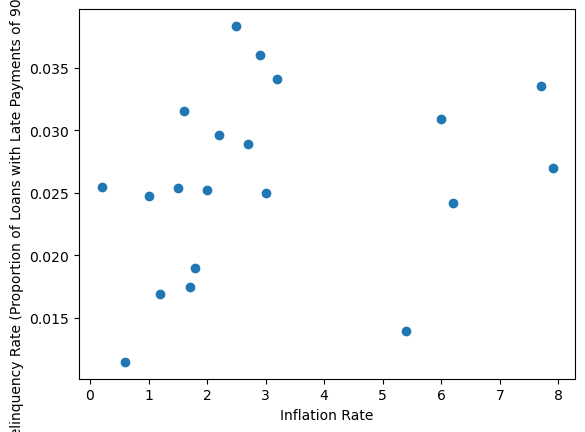

In [73]:
plt.scatter(inflat_grouped["inflat_rate"], inflat_grouped["Delinquency Rate"])
plt.xlabel("Inflation Rate")
plt.ylabel("Delinquency Rate (Proportion of Loans with Late Payments of 90+ Days)")

In [74]:
table_normalized = pd.crosstab(
    df_final_cleaned["date"],
    df_final_cleaned["Late90Days"],
    normalize='index'  # This gives row-wise (date-wise) percentages
)
table_normalized

Late90Days,0.0,1.0
date,,
201510,0.974497,0.025503
201602,0.970899,0.029101
201606,0.979268,0.020732
201610,0.966667,0.033333
201702,0.971119,0.028881
201706,0.967667,0.032333
201710,0.974742,0.025258
201802,0.970334,0.029666
201806,0.963942,0.036058


/var/folders/zg/ls8bd3c56117c99w5bccvcjw0000gn/T/ipykernel_77837/2837294837.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_cleaned["TotalBal"] = (df_final_cleaned["CreditBal"] + df_final_cleaned["MortgageBal"] + df_final_cleaned["StudentBal"] +


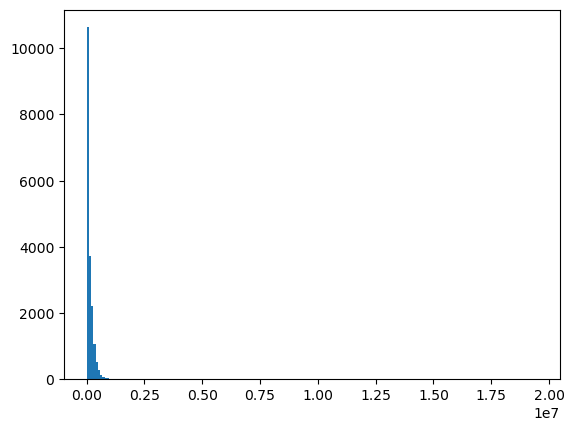

In [75]:
df_final_cleaned["TotalBal"] = (df_final_cleaned["CreditBal"] + df_final_cleaned["MortgageBal"] + df_final_cleaned["StudentBal"] + 
                          df_final_cleaned["HomeBasedBal"] + df_final_cleaned["AutoBal"] + df_final_cleaned["OtherBal"])
plt.hist(df_final_cleaned["TotalBal"], bins = 200);
plt.show()

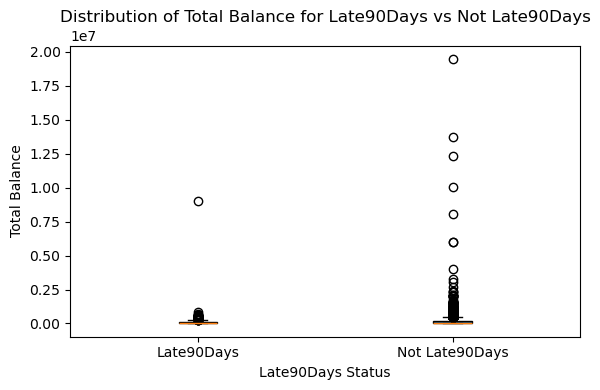

In [76]:
late = df_final_cleaned[df_final_cleaned["Late90Days"] == True]
not_late = df_final_cleaned[df_final_cleaned["Late90Days"] == False]
plt.figure(figsize=(6, 4))

plt.boxplot([late["TotalBal"], not_late["TotalBal"]], vert=True, patch_artist=True)
plt.xticks([1, 2], ["Late90Days", "Not Late90Days"])

plt.ylabel("Total Balance")
plt.xlabel("Late90Days Status")
plt.title("Distribution of Total Balance for Late90Days vs Not Late90Days")

plt.tight_layout()
plt.show()

/Users/yzhao/anaconda3/envs/info2950/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


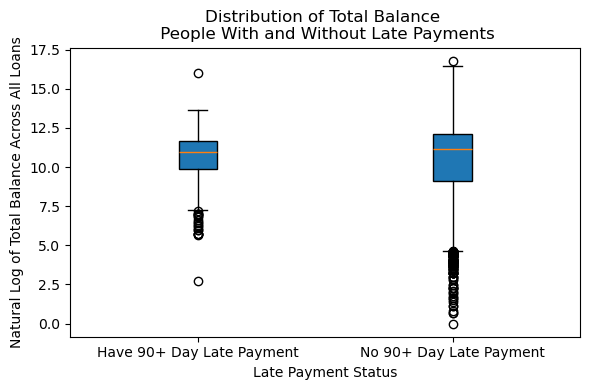

In [77]:
late = df_final_cleaned[df_final_cleaned["Late90Days"] == True]
not_late = df_final_cleaned[df_final_cleaned["Late90Days"] == False]
plt.figure(figsize=(6, 4))

plt.boxplot([np.log(late["TotalBal"]), np.log(not_late["TotalBal"])], vert=True, patch_artist=True)
plt.xticks([1, 2], ["Have 90+ Day Late Payment", "No 90+ Day Late Payment"])

plt.ylabel("Natural Log of Total Balance Across All Loans")
plt.xlabel("Late Payment Status")
plt.title("Distribution of Total Balance \n People With and Without Late Payments")

plt.tight_layout()
plt.show()

In [78]:
df_final_cleaned[["CreditBal", "MortgageBal", 
                   "StudentBal", "HomeBasedBal", "AutoBal", "OtherBal",
                   "Late30Days", "Late90Days"]].corr()

,CreditBal,MortgageBal,StudentBal,HomeBasedBal,AutoBal,OtherBal,Late30Days,Late90Days
CreditBal,1.000000,0.111665,0.004408,0.019391,0.450523,0.025393,0.016354,0.009682
MortgageBal,0.111665,1.000000,0.064296,0.031566,0.139444,0.003831,-0.035410,-0.024075
StudentBal,0.004408,0.064296,1.000000,-0.004169,0.596848,0.002350,0.021859,0.018978
HomeBasedBal,0.019391,0.031566,-0.004169,1.000000,0.043090,-0.000250,-0.004321,-0.010626
AutoBal,0.450523,0.139444,0.596848,0.043090,1.000000,0.000258,0.017104,0.004353
OtherBal,0.025393,0.003831,0.002350,-0.000250,0.000258,1.000000,0.015415,0.000028
Late30Days,0.016354,-0.035410,0.021859,-0.004321,0.017104,0.015415,1.000000,0.650335
Late90Days,0.009682,-0.024075,0.018978,-0.010626,0.004353,0.000028,0.650335,1.000000


In [79]:
credit_score = pd.get_dummies(df_final_cleaned["CreditScore"], 
                              prefix="CreditScore", 
                              drop_first=True)
last_checked = pd.get_dummies(df_final_cleaned["LastCheckCredit"], 
                              prefix="LastCheckCredit",
                              drop_first=True)
X_merged = pd.concat([df_final_cleaned, credit_score, last_checked], axis =1)
X_merged.columns
X_merged.drop(columns=["CreditScore","LastCheckCredit"])

,userid,date,weight,HaveCredit,HaveMortgage,HaveStudent,HaveHomeBasedLoan,HaveAuto,Other,CreditBal,...,CreditScore_2.0,CreditScore_3.0,CreditScore_4.0,CreditScore_5.0,CreditScore_6.0,LastCheckCredit_2.0,LastCheckCredit_3.0,LastCheckCredit_4.0,LastCheckCredit_5.0,LastCheckCredit_6.0
7004,70051996,201510,1.048000,1,0,0,0,0,0,0.0,...,False,False,True,False,False,False,False,False,True,False
7005,70052003,201510,0.491000,1,1,1,0,1,0,2000.0,...,False,False,False,True,False,False,False,True,False,False
7006,70052014,201510,0.577000,1,0,0,1,0,0,0.0,...,False,False,True,False,False,False,False,False,True,False
7008,70052043,201510,1.087000,1,0,1,0,1,0,311.0,...,False,False,False,False,False,False,True,False,False,False
7010,70052292,201510,0.784000,1,1,0,0,0,0,1500.0,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33375,75015207,202310,0.949974,1,0,0,0,0,1,3000.0,...,False,False,False,True,False,False,False,False,False,False
33376,75015209,202310,0.462812,1,1,1,1,1,0,5000.0,...,False,False,False,True,False,True,False,False,False,False
33377,75015213,202310,0.936813,1,1,0,0,1,0,1000.0,...,False,False,False,True,False,True,False,False,False,False
33379,75015225,202310,1.370018,1,0,0,0,1,0,3000.0,...,True,False,False,False,False,False,True,False,False,False


In [80]:
X = sm.add_constant(df_final_cleaned.drop(columns=["Late90Days","CreditScore",
                                                   "LastCheckCredit","date","year",
                                                   "weight", "userid","HaveCredit",'HaveMortgage', 
                                                   'HaveStudent','HaveHomeBasedLoan', 
                                                   'CreditBal', 'HomeBasedBal', 
                                                   'AutoBal', 'OtherBal',
                                                   'HaveAuto', 'Other',
                                                   "loan_count(w/outCredit)"]))
y = df_final_cleaned["Late90Days"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

logistic = sm.Logit(y_train, X_train).fit()
logistic.summary()

         Current function value: 0.038911
         Iterations: 35


/Users/yzhao/anaconda3/envs/info2950/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             Late90Days   No. Observations:                13157
Model:                          Logit   Df Residuals:                    13145
Method:                           MLE   Df Model:                           11
Date:                Sun, 11 May 2025   Pseudo R-squ.:                  0.6808
Time:                        11:43:24   Log-Likelihood:                -511.95
converged:                      False   LL-Null:                       -1603.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -17.5415    129.428     -0.136      0.892    -271.216     236.133
MortgageBal     8.99e-07   1.21e-06      0.741      0.459   -1.48e-06    3.28e-06
StudentBal     6.945e-06   2.35e-06      2.949      0.003    2.33e-06    1.16e-05
MaxedCredit      -0.0062      0.162     -0.039      0.969      -0.323       0.311
Late30Days       18.5970    129.384      0.144      0.886    -234.990     272.184
LikAble2k        -0.0113      0.002     -4.667      0.000      -0.016      -0.007
inflat_rate       0.1432      0.063      2.269      0.023       0.019       0.267
interest_rate     0.1437      0.086      1.670      0.095      -0.025       0.312
gdp           -5.604e-13   1.19e-12     -0.472      0.637   -2.89e-12    1.77e-12
gdp_cap           0.0002      0.000      0.378      0.705      -0.001       0.001
loan_count       -0.1736      0.076     -2.287      0.022      -0.322      -0.025
TotalBal      -6.116e-07   9.68e-07     -0.632      0.527   -2.51e-06    1.29e-06
=================================================================================

Possibly complete quasi-separation: A fraction 0.94 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [81]:
X_test = sm.add_constant(X_test)
predictions_test = (logistic.predict(X_test) >= 0.5).astype(int)

In [82]:
confusion_matrix(y_test, predictions_test)

array([[5436,   55],
       [  86,   63]])

## Trying Various Models, Methods to Overcome Unbalanced Data, and Model Evaluation

In [83]:
X_merged['Late90Days'] = pd.Categorical(df_final_cleaned['Late90Days'], categories=[0, 1], ordered=False).rename_categories({0: 'not late', 1: 'late'})

X_merged

,userid,date,weight,HaveCredit,HaveMortgage,HaveStudent,HaveHomeBasedLoan,HaveAuto,Other,CreditBal,...,CreditScore_2.0,CreditScore_3.0,CreditScore_4.0,CreditScore_5.0,CreditScore_6.0,LastCheckCredit_2.0,LastCheckCredit_3.0,LastCheckCredit_4.0,LastCheckCredit_5.0,LastCheckCredit_6.0
7004,70051996,201510,1.048000,1,0,0,0,0,0,0.0,...,False,False,True,False,False,False,False,False,True,False
7005,70052003,201510,0.491000,1,1,1,0,1,0,2000.0,...,False,False,False,True,False,False,False,True,False,False
7006,70052014,201510,0.577000,1,0,0,1,0,0,0.0,...,False,False,True,False,False,False,False,False,True,False
7008,70052043,201510,1.087000,1,0,1,0,1,0,311.0,...,False,False,False,False,False,False,True,False,False,False
7010,70052292,201510,0.784000,1,1,0,0,0,0,1500.0,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33375,75015207,202310,0.949974,1,0,0,0,0,1,3000.0,...,False,False,False,True,False,False,False,False,False,False
33376,75015209,202310,0.462812,1,1,1,1,1,0,5000.0,...,False,False,False,True,False,True,False,False,False,False
33377,75015213,202310,0.936813,1,1,0,0,1,0,1000.0,...,False,False,False,True,False,True,False,False,False,False
33379,75015225,202310,1.370018,1,0,0,0,1,0,3000.0,...,True,False,False,False,False,False,True,False,False,False


In [84]:
X = X_merged.drop(columns=["Late90Days","Late30Days","userid","date","weight","HaveCredit",
                                   'HaveMortgage',"loan_count(w/outCredit)","LastCheckCredit","year"])



Y = X_merged["Late90Days"]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=Y)
# Store the original column names before scaling
feature_names = X.columns.tolist()
#used to downsample outcomes as we have a 97% to 3%split
rus = RandomUnderSampler(random_state=42)
X_train_down, y_train_down = rus.fit_resample(X_train, y_train)
#will be used for folds
cv=StratifiedKFold(n_splits=5,random_state=1,shuffle=True)


In [85]:
scaler=StandardScaler()

X_train_scaled_down=scaler.fit_transform(X_train_down)
X_test_scaled=scaler.transform(X_test)

# Convert scaled arrays back to DataFrame to preserve column names
X_train_scaled_down = pd.DataFrame(X_train_scaled_down, columns=feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

In [86]:
# Grid search for regularization with resampled data
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # liblinear supports both L1 and L2
}

grid_search = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid,
    cv=cv,
    scoring=['accuracy',"roc_auc"],
    n_jobs=-1,
    verbose=1,
    refit="roc_auc"
)

# Use your resampled data here
grid_search.fit(X_train_scaled_down, y_train_down)
log_down = grid_search.best_estimator_
# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best ROC AUC:", grid_search.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best ROC AUC: 0.9403582680709335



Feature Coeffiecent Analysis:
                Feature  Importance
11          CreditScore    0.034121
20      CreditScore_3.0    0.019082
23      CreditScore_6.0    0.016138
19      CreditScore_2.0    0.007752
14        interest_rate    0.000000
15                  gdp    0.000000
27  LastCheckCredit_5.0    0.000000
26  LastCheckCredit_4.0    0.000000
25  LastCheckCredit_3.0    0.000000
24  LastCheckCredit_2.0    0.000000
22      CreditScore_5.0    0.000000
18             TotalBal    0.000000
17           loan_count    0.000000
16              gdp_cap    0.000000
28  LastCheckCredit_6.0    0.000000
1     HaveHomeBasedLoan    0.000000
13          inflat_rate    0.000000
8               AutoBal    0.000000
7          HomeBasedBal    0.000000
6            StudentBal    0.000000
5           MortgageBal    0.000000
4             CreditBal    0.000000
3                 Other    0.000000
2              HaveAuto    0.000000
9              OtherBal   -0.000277
21      CreditScore_4.0   -0.0011

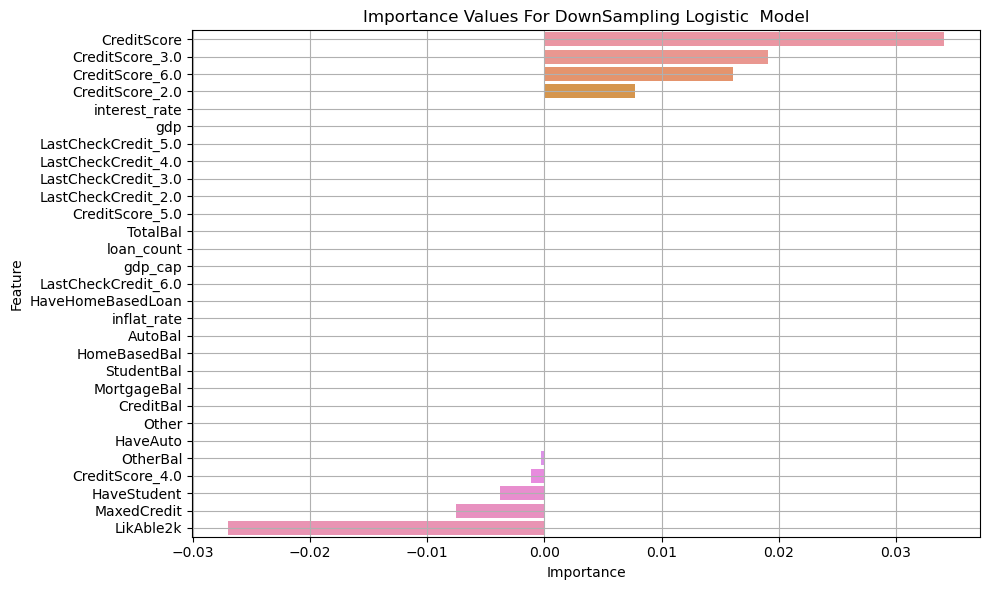

In [87]:
result = permutation_importance(log_down, X_test_scaled, y_test, n_repeats=50, random_state=42, n_jobs=-1)
print("\nFeature Coeffiecent Analysis:")

log_feature_down = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': result.importances_mean
}).sort_values('Importance', ascending=False)

print(log_feature_down)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=log_feature_down)
plt.title('Importance Values For DownSampling Logistic  Model')
plt.tight_layout()
plt.grid(True)

In [88]:
y_pred= log_down.predict(X_test_scaled)

In [89]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        late       0.15      0.93      0.26       149
    not late       1.00      0.86      0.92      5491

    accuracy                           0.86      5640
   macro avg       0.57      0.89      0.59      5640
weighted avg       0.98      0.86      0.90      5640



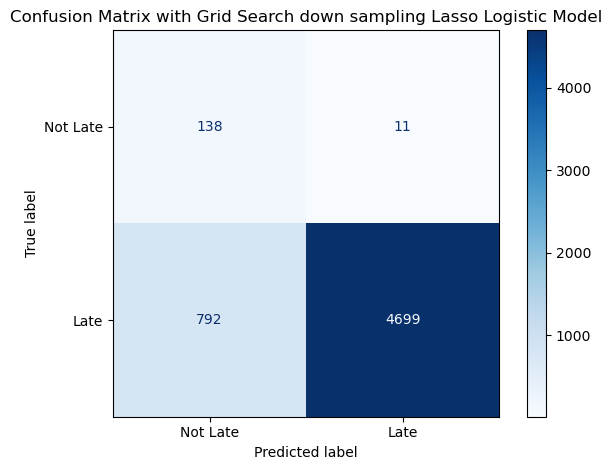

In [90]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,y_pred),display_labels=["Not Late", "Late"]).plot(cmap='Blues')
plt.title('Confusion Matrix with Grid Search down sampling Lasso Logistic Model')
plt.tight_layout()

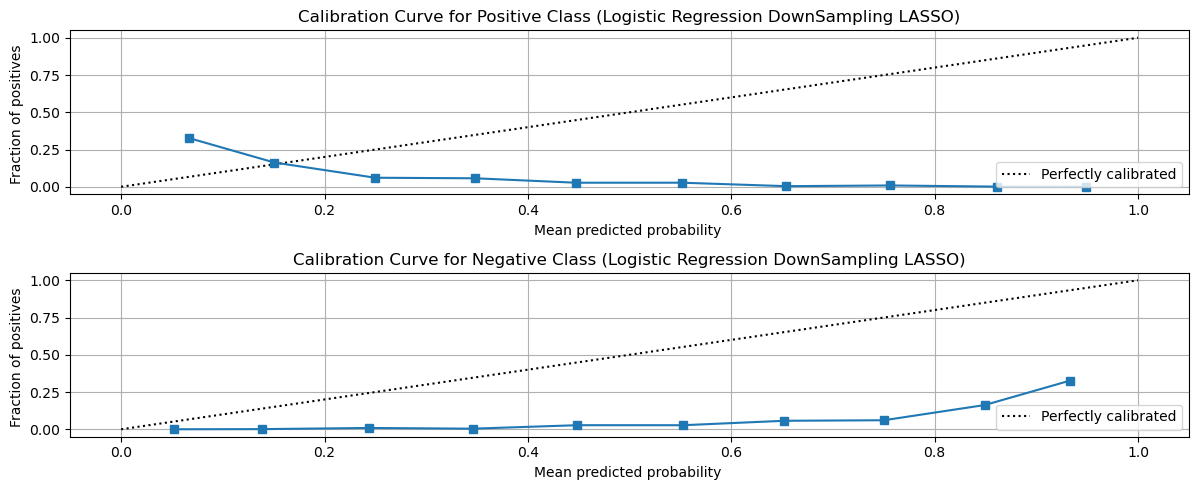

In [91]:
# Convert labels
y_test_numeric = y_test.map({'not late': 0, 'late': 1})

y_pred_proba_pos = log_down.predict_proba(X_test_scaled)[:, 1]
y_pred_proba_neg = log_down.predict_proba(X_test_scaled)[:, 0]

fig, axes = plt.subplots(2, 1, figsize=(12, 5))

# Positive class calibration
prob_true_pos, prob_pred_pos = calibration_curve(y_test_numeric, y_pred_proba_pos, n_bins=10)
CalibrationDisplay(prob_true=prob_true_pos, prob_pred=prob_pred_pos, y_prob=y_pred_proba_pos).plot(ax=axes[0])
axes[0].set_title("Calibration Curve for Positive Class (Logistic Regression DownSampling LASSO)")
axes[0].grid(True)

# Negative class calibration
prob_true_neg, prob_pred_neg = calibration_curve(y_test_numeric, y_pred_proba_neg, n_bins=10)
CalibrationDisplay(prob_true=prob_true_neg, prob_pred=prob_pred_neg, y_prob=y_pred_proba_neg).plot(ax=axes[1])
axes[1].set_title("Calibration Curve for Negative Class (Logistic Regression DownSampling LASSO)")
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Logistic With UpSampling

In [92]:
ros = RandomOverSampler(random_state=42)
X_train_up, y_train_up = ros.fit_resample(X_train, y_train)

scaler=StandardScaler()

X_train_scaled_up=scaler.fit_transform(X_train_up)
X_test_scaled=scaler.transform(X_test)

# Convert scaled arrays back to DataFrame to preserve column names
X_train_scaled_up = pd.DataFrame(X_train_scaled_up, columns=feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)


In [93]:
grid_search = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid,
    cv=cv,
    scoring=['accuracy',"roc_auc"],
    n_jobs=-1,
    verbose=1,
    refit="roc_auc"
)

grid_search.fit(X_train_scaled_up, y_train_up)
log_up = grid_search.best_estimator_
# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best ROC AUC:", grid_search.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best ROC AUC: 0.9418448701705892


In [94]:
y_pred= log_up.predict(X_test_scaled)
# Calculate metrics
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        late       0.17      0.91      0.28       149
    not late       1.00      0.88      0.93      5491

    accuracy                           0.88      5640
   macro avg       0.58      0.89      0.61      5640
weighted avg       0.98      0.88      0.92      5640



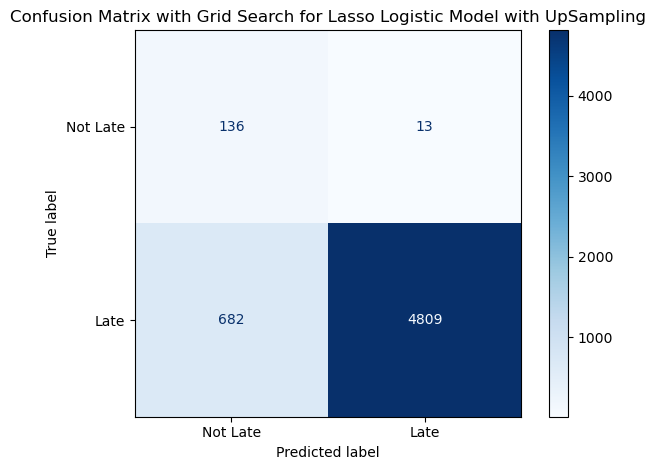

In [95]:
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,y_pred),display_labels=["Not Late", "Late"]).plot(cmap='Blues')
plt.title('Confusion Matrix with Grid Search for Lasso Logistic Model with UpSampling')
plt.tight_layout()

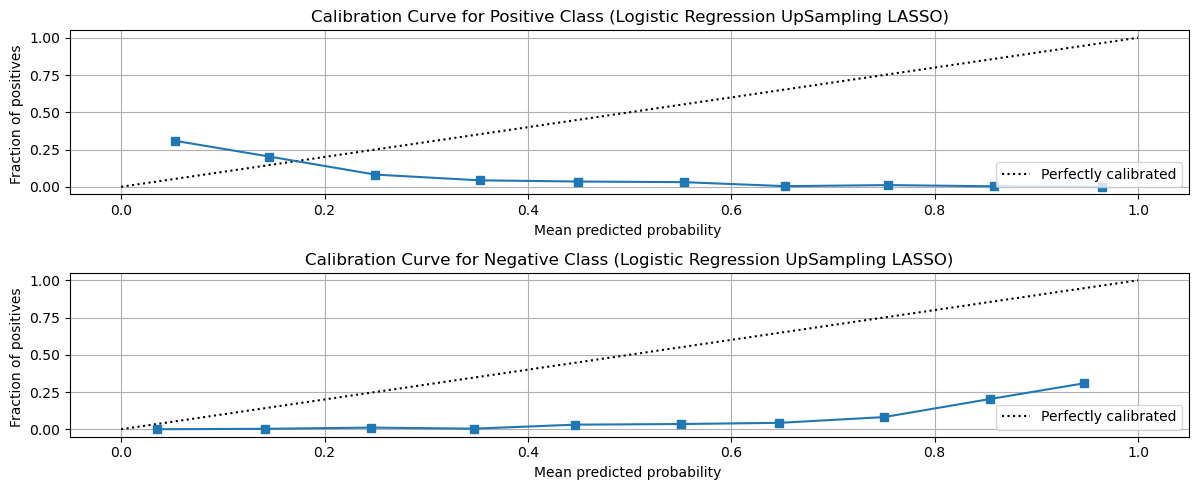

In [ ]:
y_test_numeric = y_test.map({'not late': 0, 'late': 1})

y_pred_proba_pos = log_up.predict_proba(X_test_scaled)[:, 1]
y_pred_proba_neg = log_up.predict_proba(X_test_scaled)[:, 0]

fig, axes = plt.subplots(2, 1, figsize=(12, 5))

# Positive class calibration
prob_true_pos, prob_pred_pos = calibration_curve(y_test_numeric, y_pred_proba_pos, n_bins=10)
CalibrationDisplay(prob_true=prob_true_pos, prob_pred=prob_pred_pos, y_prob=y_pred_proba_pos).plot(ax=axes[0])
axes[0].set_title("Calibration Curve for Positive Class (Logistic Regression UpSampling LASSO)")
axes[0].grid(True)

# Negative class calibration
prob_true_neg, prob_pred_neg = calibration_curve(y_test_numeric, y_pred_proba_neg, n_bins=10)
CalibrationDisplay(prob_true=prob_true_neg, prob_pred=prob_pred_neg, y_prob=y_pred_proba_neg).plot(ax=axes[1])
axes[1].set_title("Calibration Curve for Negative Class (Logistic Regression UpSampling LASSO)")
axes[1].grid(True)

plt.tight_layout()
plt.show()


Feature Coeffiecent Analysis:
                Feature  Importance
16              gdp_cap    0.183131
15                  gdp    0.168918
20      CreditScore_3.0    0.054021
19      CreditScore_2.0    0.028745
21      CreditScore_4.0    0.022245
13          inflat_rate    0.007472
17           loan_count    0.005745
5           MortgageBal    0.003606
6            StudentBal    0.002755
28  LastCheckCredit_6.0    0.001457
1     HaveHomeBasedLoan    0.001436
14        interest_rate    0.001344
18             TotalBal    0.001266
4             CreditBal    0.000982
8               AutoBal    0.000266
2              HaveAuto    0.000184
9              OtherBal    0.000078
7          HomeBasedBal    0.000067
25  LastCheckCredit_3.0   -0.000067
27  LastCheckCredit_5.0   -0.000585
26  LastCheckCredit_4.0   -0.000617
24  LastCheckCredit_2.0   -0.000716
0           HaveStudent   -0.002103
3                 Other   -0.002695
23      CreditScore_6.0   -0.004894
10          MaxedCredit   -0.0076

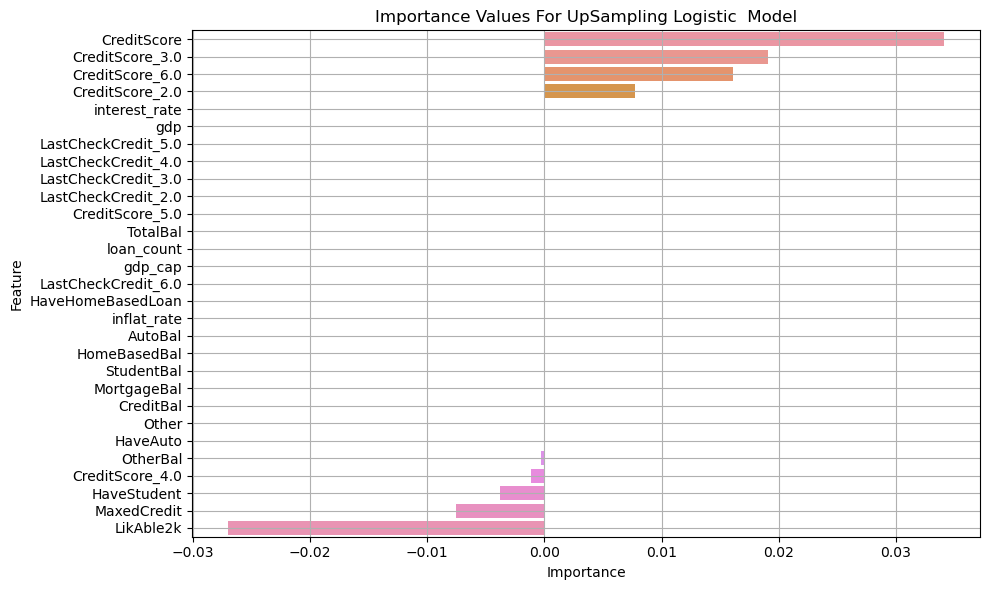

In [117]:
result = permutation_importance(log_up, X_test_scaled, y_test, n_repeats=50, random_state=42, n_jobs=-1)
print("\nFeature Coeffiecent Analysis:")

log_feature_up = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': result.importances_mean
}).sort_values('Importance', ascending=False)

print(log_feature_up)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=log_feature_down)
plt.title('Importance Values For UpSampling Logistic  Model')
plt.tight_layout()
plt.grid(True)

## Random Forest
### Up Sampling

In [98]:
rf_param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20],
    'max_features': [None, 'sqrt', 'log2']
}

rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), 
                       rf_param_grid, cv=cv,
                        scoring=['accuracy',"roc_auc"], 
                        n_jobs=-1, 
                        verbose=3,
                        refit="roc_auc")
rf_grid.fit(X_train_up, y_train_up)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 5/5] END max_depth=None, max_features=None, n_estimators=100; accuracy: (test=0.992) roc_auc: (test=1.000) total time=  24.7s
[CV 1/5] END max_depth=None, max_features=None, n_estimators=100; accuracy: (test=0.992) roc_auc: (test=1.000) total time=  25.6s
[CV 3/5] END max_depth=None, max_features=None, n_estimators=100; accuracy: (test=0.995) roc_auc: (test=1.000) total time=  25.5s
[CV 4/5] END max_depth=None, max_features=None, n_estimators=100; accuracy: (test=0.993) roc_auc: (test=1.000) total time=  25.5s
[CV 2/5] END max_depth=None, max_features=None, n_estimators=100; accuracy: (test=0.991) roc_auc: (test=1.000) total time=  25.8s
[CV 3/5] END max_depth=None, max_features=None, n_estimators=300; accuracy: (test=0.995) roc_auc: (test=1.000) total time=  47.4s
[CV 1/5] END max_depth=None, max_features=None, n_estimators=300; accuracy: (test=0.993) roc_auc: (test=1.000) total time=  48.3s
[CV 2/5] END max_depth=None,

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'max_features': [None, 'sqrt', 'log2'],
                         'n_estimators': [100, 300, 500]},
             refit='roc_auc', scoring=['accuracy', 'roc_auc'], verbose=3)

In [99]:
print(f" Best Score is:", rf_grid.best_score_)
print(f"Best Parameter are :",rf_grid.best_estimator_)
rand_up=rf_grid.best_estimator_

 Best Score is: 0.9999847650248848
Best Parameter are : RandomForestClassifier(max_depth=20, max_features=None, n_estimators=500,
                       random_state=42)


In [100]:
rand_pred_up= rand_up.predict(X_test)
print(classification_report(y_test, rand_pred_up))

              precision    recall  f1-score   support

        late       0.29      0.32      0.30       149
    not late       0.98      0.98      0.98      5491

    accuracy                           0.96      5640
   macro avg       0.64      0.65      0.64      5640
weighted avg       0.96      0.96      0.96      5640



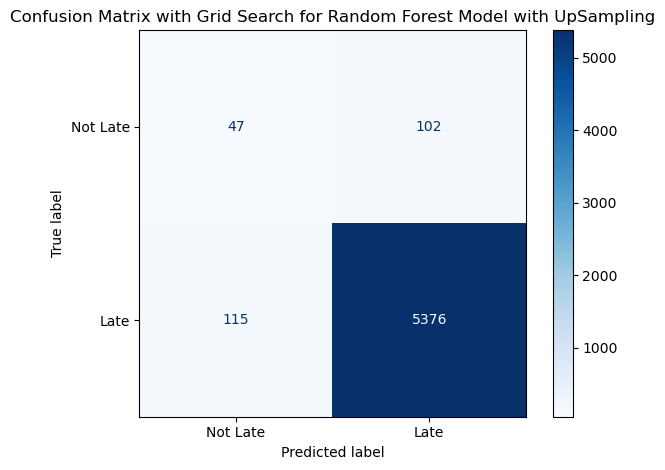

In [101]:
conf_matrix = confusion_matrix(y_test, rand_pred_up)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=["Not Late", "Late"]).plot(cmap='Blues')
plt.title('Confusion Matrix with Grid Search for Random Forest Model with UpSampling')
plt.tight_layout()

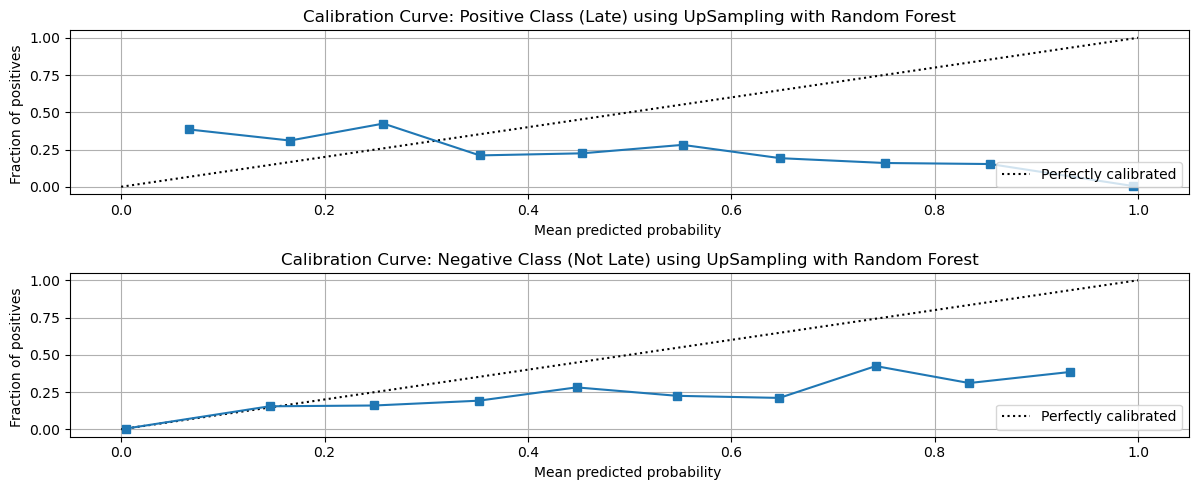

In [102]:
y_test_numeric = y_test.map({'not late': 0, 'late': 1})

y_pred_proba_pos = rand_up.predict_proba(X_test)[:, 1]
y_pred_proba_neg = rand_up.predict_proba(X_test)[:, 0]

fig, axes = plt.subplots(2, 1, figsize=(12, 5))

# Positive class calibration
prob_true_pos, prob_pred_pos = calibration_curve(y_test_numeric, y_pred_proba_pos, n_bins=10)
CalibrationDisplay(prob_true=prob_true_pos, prob_pred=prob_pred_pos, y_prob=y_pred_proba_pos).plot(ax=axes[0])
axes[0].set_title("Calibration Curve: Positive Class (Late) using UpSampling with Random Forest")
axes[0].grid(True)

# Negative class calibration
prob_true_neg, prob_pred_neg = calibration_curve(y_test_numeric, y_pred_proba_neg, n_bins=10)
CalibrationDisplay(prob_true=prob_true_neg, prob_pred=prob_pred_neg, y_prob=y_pred_proba_neg).plot(ax=axes[1])
axes[1].set_title("Calibration Curve: Negative Class (Not Late) using UpSampling with Random Forest")
axes[1].grid(True)

plt.tight_layout()
plt.show()


Feature Coeffiecent Analysis:
                Feature  Importance
11          CreditScore    0.547235
12            LikAble2k    0.104817
18             TotalBal    0.065508
4             CreditBal    0.044485
14        interest_rate    0.031819
6            StudentBal    0.025974
8               AutoBal    0.024076
13          inflat_rate    0.021867
19      CreditScore_2.0    0.019964
5           MortgageBal    0.017268
23      CreditScore_6.0    0.014827
9              OtherBal    0.013364
17           loan_count    0.010350
15                  gdp    0.008092
16              gdp_cap    0.007977
10          MaxedCredit    0.006429
25  LastCheckCredit_3.0    0.005857
21      CreditScore_4.0    0.004864
24  LastCheckCredit_2.0    0.004807
26  LastCheckCredit_4.0    0.003591
27  LastCheckCredit_5.0    0.003296
7          HomeBasedBal    0.003009
20      CreditScore_3.0    0.002494
2              HaveAuto    0.002182
28  LastCheckCredit_6.0    0.001350
0           HaveStudent    0.0012

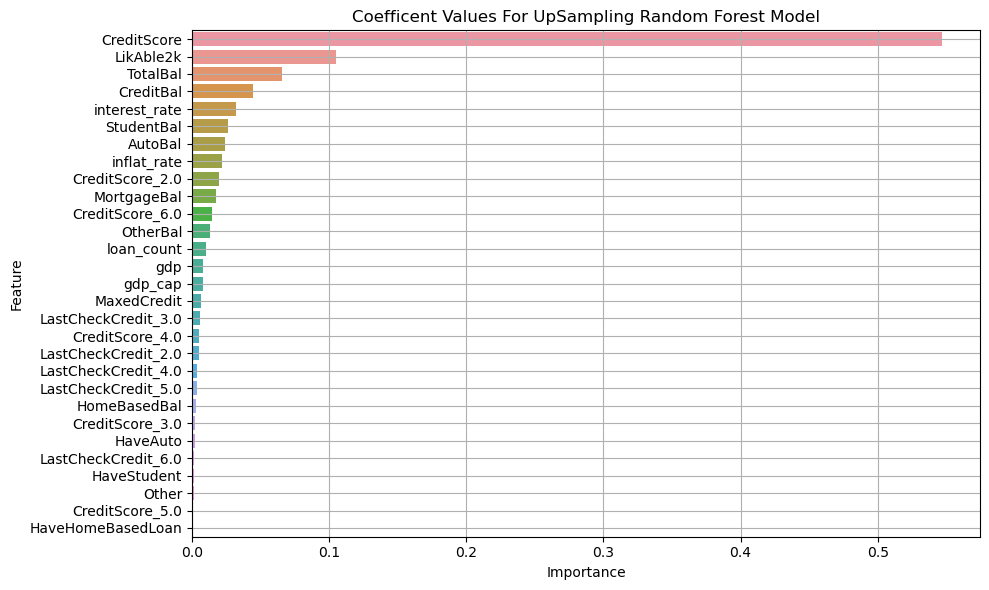

In [103]:
print("\nFeature Coeffiecent Analysis:")
rand_up_import = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rand_up.feature_importances_
}).sort_values('Importance', ascending=False)
print(rand_up_import)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=rand_up_import)
plt.title('Coefficent Values For UpSampling Random Forest Model')
plt.tight_layout()
plt.grid(True)


### Down Sampling

In [104]:
rf_grid.fit(X_train_down,y_train_down)
print(f" Best Score is:", rf_grid.best_score_)
print(f"Best Parameter are :",rf_grid.best_estimator_)
rand_down=rf_grid.best_estimator_

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END max_depth=None, max_features=None, n_estimators=100; accuracy: (test=0.835) roc_auc: (test=0.913) total time=   0.4s
[CV 2/5] END max_depth=None, max_features=None, n_estimators=100; accuracy: (test=0.849) roc_auc: (test=0.931) total time=   0.4s
[CV 3/5] END max_depth=None, max_features=None, n_estimators=100; accuracy: (test=0.885) roc_auc: (test=0.935) total time=   0.4s
[CV 5/5] END max_depth=None, max_features=None, n_estimators=100; accuracy: (test=0.833) roc_auc: (test=0.902) total time=   0.4s
[CV 4/5] END max_depth=None, max_features=None, n_estimators=100; accuracy: (test=0.899) roc_auc: (test=0.915) total time=   0.4s
[CV 1/5] END max_depth=None, max_features=None, n_estimators=300; accuracy: (test=0.820) roc_auc: (test=0.913) total time=   1.2s
[CV 2/5] END max_depth=None, max_features=None, n_estimators=300; accuracy: (test=0.856) roc_auc: (test=0.938) total time=   1.3s
[CV 3/5] END max_depth=None,

              precision    recall  f1-score   support

        late       0.15      0.93      0.26       149
    not late       1.00      0.86      0.92      5491

    accuracy                           0.86      5640
   macro avg       0.57      0.89      0.59      5640
weighted avg       0.98      0.86      0.90      5640



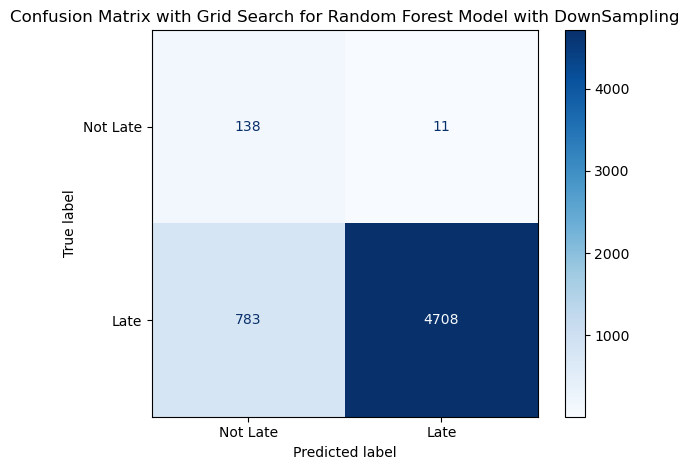

In [105]:
rand_pred_down= rand_down.predict(X_test)
print(classification_report(y_test, rand_pred_down))

ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,rand_pred_down),display_labels=["Not Late", "Late"]).plot(cmap='Blues')
plt.title('Confusion Matrix with Grid Search for Random Forest Model with DownSampling')
plt.tight_layout()

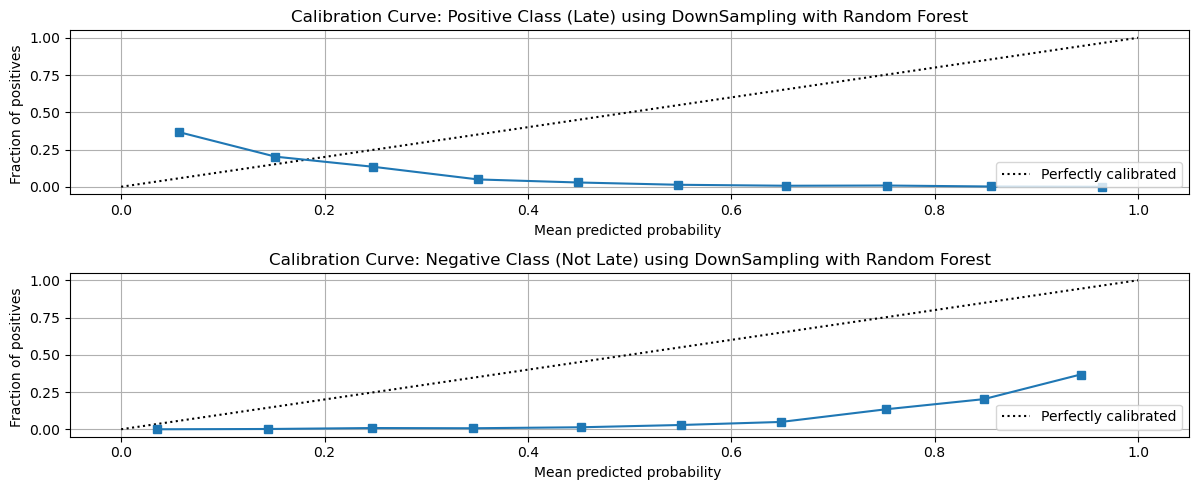

In [106]:
y_pred_proba_pos = rand_down.predict_proba(X_test)[:, 1]
y_pred_proba_neg = rand_down.predict_proba(X_test)[:, 0]

fig, axes = plt.subplots(2, 1, figsize=(12, 5))

# Positive class calibration
prob_true_pos, prob_pred_pos = calibration_curve(y_test_numeric, y_pred_proba_pos, n_bins=10)
CalibrationDisplay(prob_true=prob_true_pos, prob_pred=prob_pred_pos, y_prob=y_pred_proba_pos).plot(ax=axes[0])
axes[0].set_title("Calibration Curve: Positive Class (Late) using DownSampling with Random Forest")
axes[0].grid(True)

# Negative class calibration
prob_true_neg, prob_pred_neg = calibration_curve(y_test_numeric, y_pred_proba_neg, n_bins=10)
CalibrationDisplay(prob_true=prob_true_neg, prob_pred=prob_pred_neg, y_prob=y_pred_proba_neg).plot(ax=axes[1])
axes[1].set_title("Calibration Curve: Negative Class (Not Late) using DownSampling with Random Forest")
axes[1].grid(True)

plt.tight_layout()
plt.show()


Feature Coeffiecent Analysis:
                Feature  Importance
11          CreditScore    0.547235
12            LikAble2k    0.104817
18             TotalBal    0.065508
4             CreditBal    0.044485
14        interest_rate    0.031819
6            StudentBal    0.025974
8               AutoBal    0.024076
13          inflat_rate    0.021867
19      CreditScore_2.0    0.019964
5           MortgageBal    0.017268
23      CreditScore_6.0    0.014827
9              OtherBal    0.013364
17           loan_count    0.010350
15                  gdp    0.008092
16              gdp_cap    0.007977
10          MaxedCredit    0.006429
25  LastCheckCredit_3.0    0.005857
21      CreditScore_4.0    0.004864
24  LastCheckCredit_2.0    0.004807
26  LastCheckCredit_4.0    0.003591
27  LastCheckCredit_5.0    0.003296
7          HomeBasedBal    0.003009
20      CreditScore_3.0    0.002494
2              HaveAuto    0.002182
28  LastCheckCredit_6.0    0.001350
0           HaveStudent    0.0012

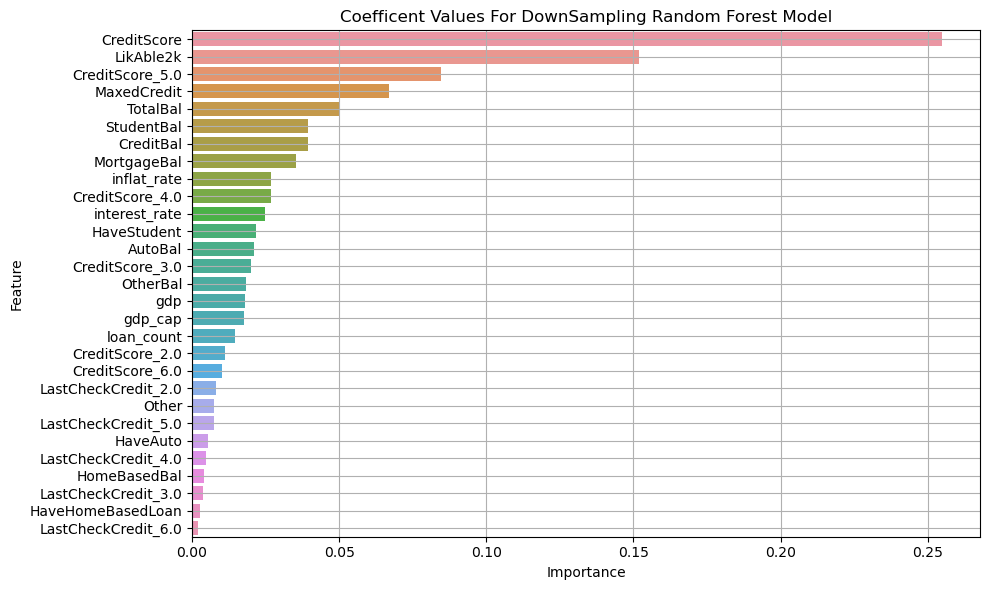

In [107]:
print("\nFeature Coeffiecent Analysis:")
rand_down_import = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rand_down.feature_importances_
}).sort_values('Importance', ascending=False)
print(rand_up_import)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=rand_down_import)
plt.title('Coefficent Values For DownSampling Random Forest Model')
plt.tight_layout()
plt.grid(True)

## HistGradientBoostingClassifier
### UpSampling

In [108]:
hgb_param_grid = {
    'learning_rate': [0.1, 0.05, 0.01],
    'max_iter': [100, 300, 500],
    'max_depth': [None, 5, 10],
    'l2_regularization': [0.0, 0.1, 1.0, 10.0]
}

hgb_grid = GridSearchCV(HistGradientBoostingClassifier(random_state=42), 
                        hgb_param_grid, 
                        cv=cv, 
                        scoring=["roc_auc",'accuracy'], 
                        n_jobs=-1, 
                        verbose=3,
                        refit="roc_auc")


In [109]:
hgb_grid.fit(X_train_up, y_train_up)
print(f" Best Score is:", hgb_grid.best_score_)
print(f"Best Parameter are :",hgb_grid.best_estimator_)
hgb_up=hgb_grid.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 2/5] END l2_regularization=0.0, learning_rate=0.1, max_depth=None, max_iter=100; accuracy: (test=0.977) roc_auc: (test=0.997) total time=   2.1s
[CV 1/5] END l2_regularization=0.0, learning_rate=0.1, max_depth=None, max_iter=100; accuracy: (test=0.975) roc_auc: (test=0.997) total time=   2.1s
[CV 5/5] END l2_regularization=0.0, learning_rate=0.1, max_depth=None, max_iter=100; accuracy: (test=0.972) roc_auc: (test=0.997) total time=   2.0s
[CV 4/5] END l2_regularization=0.0, learning_rate=0.1, max_depth=None, max_iter=100; accuracy: (test=0.976) roc_auc: (test=0.997) total time=   2.1s
[CV 3/5] END l2_regularization=0.0, learning_rate=0.1, max_depth=None, max_iter=100; accuracy: (test=0.974) roc_auc: (test=0.997) total time=   2.2s
[CV 2/5] END l2_regularization=0.0, learning_rate=0.1, max_depth=None, max_iter=300; accuracy: (test=0.990) roc_auc: (test=1.000) total time=   5.1s
[CV 3/5] END l2_regularization=0.0, learnin

              precision    recall  f1-score   support

        late       0.38      0.34      0.35       149
    not late       0.98      0.98      0.98      5491

    accuracy                           0.97      5640
   macro avg       0.68      0.66      0.67      5640
weighted avg       0.97      0.97      0.97      5640



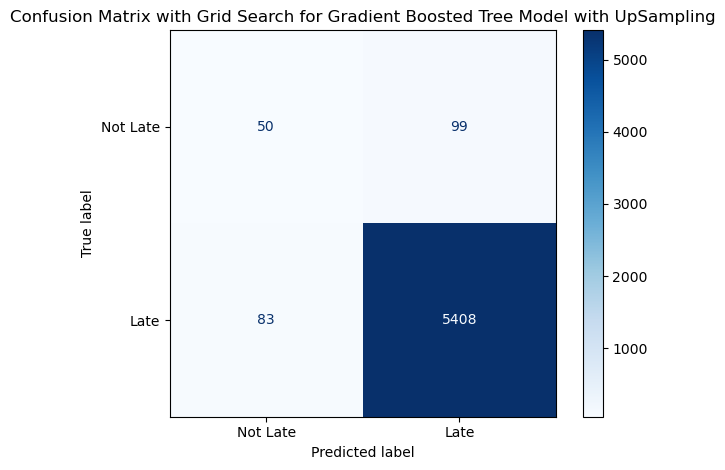

In [110]:
hgb_pred_up= hgb_up.predict(X_test)
print(classification_report(y_test, hgb_pred_up))

ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,hgb_pred_up),display_labels=["Not Late", "Late"]).plot(cmap='Blues')
plt.title('Confusion Matrix with Grid Search for Gradient Boosted Tree Model with UpSampling')
plt.tight_layout()

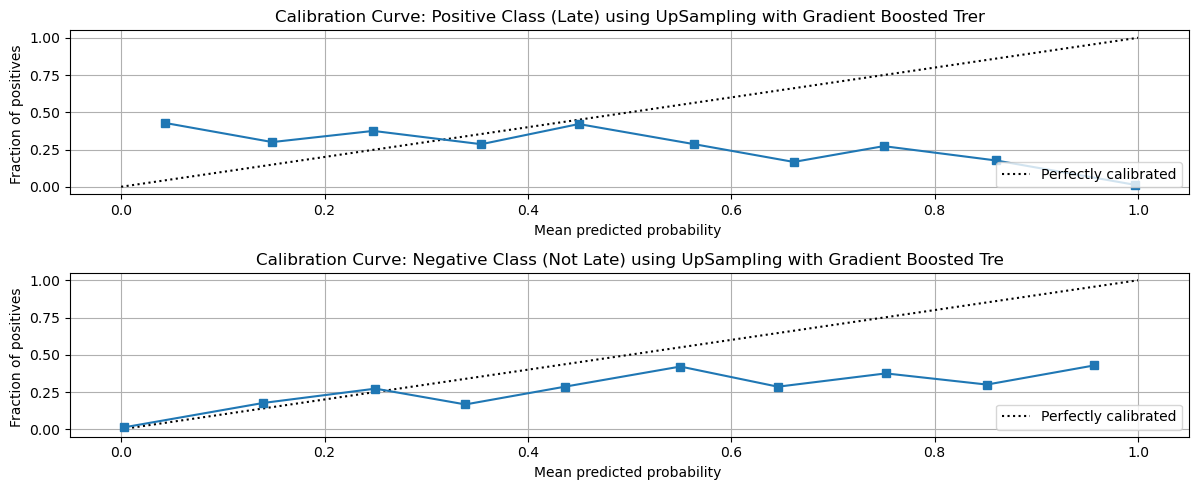

In [111]:
y_pred_proba_pos = hgb_up.predict_proba(X_test)[:, 1]
y_pred_proba_neg = hgb_up.predict_proba(X_test)[:, 0]

fig, axes = plt.subplots(2, 1, figsize=(12, 5))

# Positive class calibration
prob_true_pos, prob_pred_pos = calibration_curve(y_test_numeric, y_pred_proba_pos, n_bins=10)
CalibrationDisplay(prob_true=prob_true_pos, prob_pred=prob_pred_pos, y_prob=y_pred_proba_pos).plot(ax=axes[0])
axes[0].set_title("Calibration Curve: Positive Class (Late) using UpSampling with Gradient Boosted Trer")
axes[0].grid(True)

# Negative class calibration
prob_true_neg, prob_pred_neg = calibration_curve(y_test_numeric, y_pred_proba_neg, n_bins=10)
CalibrationDisplay(prob_true=prob_true_neg, prob_pred=prob_pred_neg, y_prob=y_pred_proba_neg).plot(ax=axes[1])
axes[1].set_title("Calibration Curve: Negative Class (Not Late) using UpSampling with Gradient Boosted Tre")
axes[1].grid(True)

plt.tight_layout()
plt.show()


Feature Importance Analysis:
                Feature  Importance
18             TotalBal    0.002833
6            StudentBal    0.001344
8               AutoBal    0.001248
24  LastCheckCredit_2.0    0.001195
5           MortgageBal    0.000936
19      CreditScore_2.0    0.000390
25  LastCheckCredit_3.0    0.000241
0           HaveStudent    0.000216
26  LastCheckCredit_4.0    0.000206
28  LastCheckCredit_6.0    0.000160
1     HaveHomeBasedLoan    0.000014
16              gdp_cap    0.000000
23      CreditScore_6.0   -0.000011
27  LastCheckCredit_5.0   -0.000043
3                 Other   -0.000043
2              HaveAuto   -0.000106
20      CreditScore_3.0   -0.000209
7          HomeBasedBal   -0.000266
13          inflat_rate   -0.000404
21      CreditScore_4.0   -0.000408
14        interest_rate   -0.000418
4             CreditBal   -0.000422
15                  gdp   -0.000493
17           loan_count   -0.000695
9              OtherBal   -0.000787
10          MaxedCredit   -0.00110

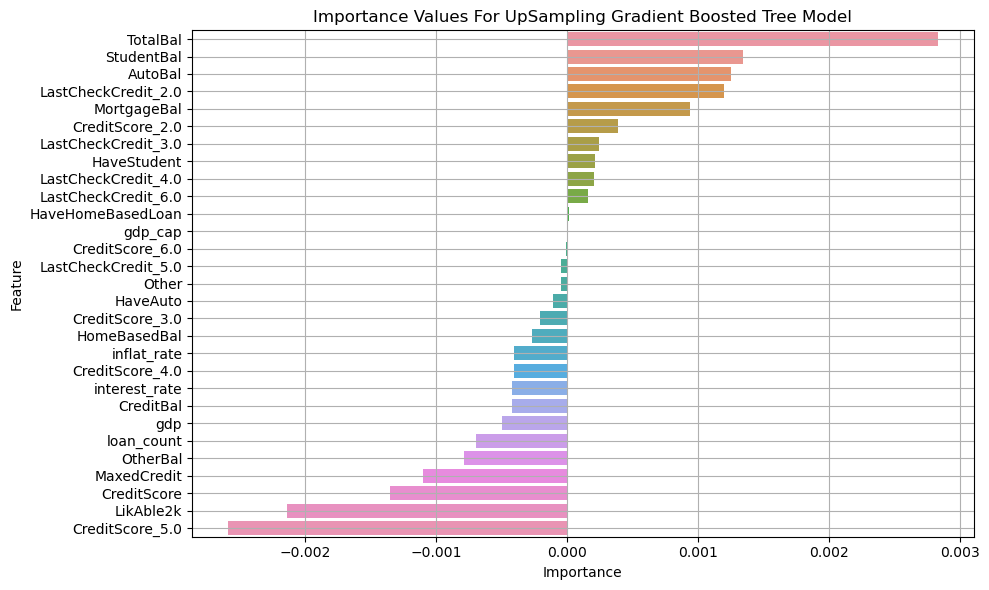

In [112]:
result = permutation_importance(hgb_up, X_test, y_test, n_repeats=50, random_state=42, n_jobs=-1)
print("\nFeature Importance Analysis:")
# Build DataFrame
hgbup_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': result.importances_mean
}).sort_values('Importance', ascending=False)

print(hgbup_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=hgbup_df)
plt.title('Importance Values For UpSampling Gradient Boosted Tree Model')
plt.tight_layout()
plt.grid(True)

### DownSampling

In [113]:
hgb_grid.fit(X_train_down, y_train_down)
print(f" Best Score is:", hgb_grid.best_score_)
print(f"Best Parameter are :",hgb_grid.best_estimator_)
hbg_down=hgb_grid.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 3/5] END l2_regularization=0.0, learning_rate=0.1, max_depth=None, max_iter=100; accuracy: (test=0.899) roc_auc: (test=0.916) total time=   0.2s
[CV 2/5] END l2_regularization=0.0, learning_rate=0.1, max_depth=None, max_iter=100; accuracy: (test=0.863) roc_auc: (test=0.925) total time=   0.3s
[CV 1/5] END l2_regularization=0.0, learning_rate=0.1, max_depth=None, max_iter=100; accuracy: (test=0.871) roc_auc: (test=0.911) total time=   0.3s
[CV 4/5] END l2_regularization=0.0, learning_rate=0.1, max_depth=None, max_iter=100; accuracy: (test=0.863) roc_auc: (test=0.923) total time=   0.3s
[CV 5/5] END l2_regularization=0.0, learning_rate=0.1, max_depth=None, max_iter=100; accuracy: (test=0.819) roc_auc: (test=0.889) total time=   0.3s
[CV 1/5] END l2_regularization=0.0, learning_rate=0.1, max_depth=None, max_iter=300; accuracy: (test=0.871) roc_auc: (test=0.901) total time=   0.9s
[CV 2/5] END l2_regularization=0.0, learnin

              precision    recall  f1-score   support

        late       0.15      0.92      0.25       149
    not late       1.00      0.85      0.92      5491

    accuracy                           0.85      5640
   macro avg       0.57      0.89      0.59      5640
weighted avg       0.97      0.85      0.90      5640



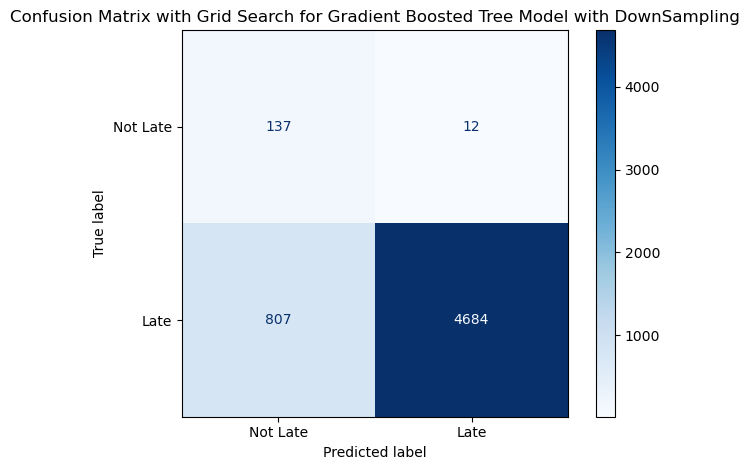

In [114]:
hgb_pred_down= hbg_down.predict(X_test)
print(classification_report(y_test, hgb_pred_down))

ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,hgb_pred_down),display_labels=["Not Late", "Late"]).plot(cmap='Blues')
plt.title('Confusion Matrix with Grid Search for Gradient Boosted Tree Model with DownSampling')
plt.tight_layout()

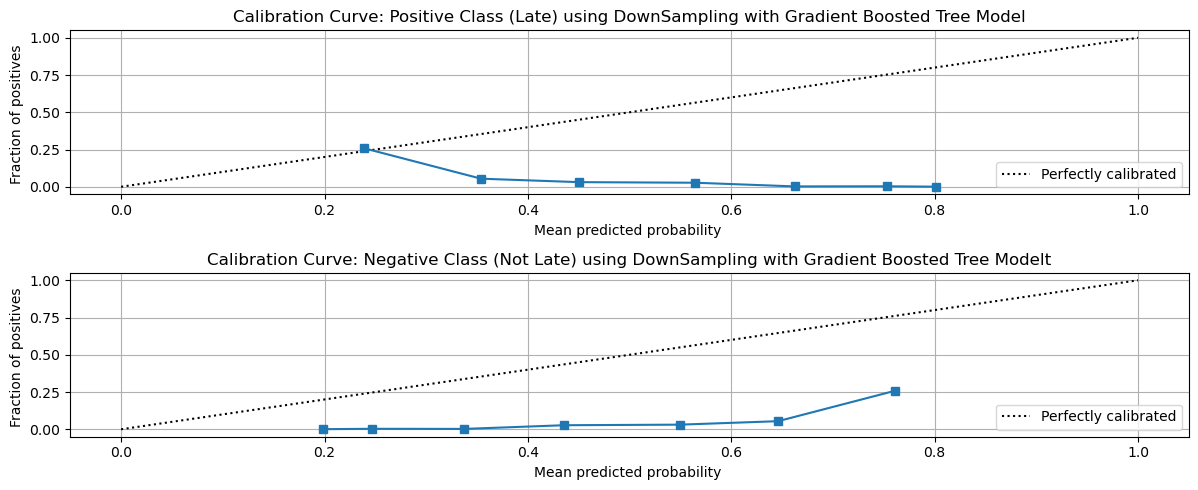

In [115]:
y_pred_proba_pos = hbg_down.predict_proba(X_test)[:, 1]
y_pred_proba_neg = hbg_down.predict_proba(X_test)[:, 0]

fig, axes = plt.subplots(2, 1, figsize=(12, 5))

# Positive class calibration
prob_true_pos, prob_pred_pos = calibration_curve(y_test_numeric, y_pred_proba_pos, n_bins=10)
CalibrationDisplay(prob_true=prob_true_pos, prob_pred=prob_pred_pos, y_prob=y_pred_proba_pos).plot(ax=axes[0])
axes[0].set_title("Calibration Curve: Positive Class (Late) using DownSampling with Gradient Boosted Tree Model")
axes[0].grid(True)

# Negative class calibration
prob_true_neg, prob_pred_neg = calibration_curve(y_test_numeric, y_pred_proba_neg, n_bins=10)
CalibrationDisplay(prob_true=prob_true_neg, prob_pred=prob_pred_neg, y_prob=y_pred_proba_neg).plot(ax=axes[1])
axes[1].set_title("Calibration Curve: Negative Class (Not Late) using DownSampling with Gradient Boosted Tree Modelt")
axes[1].grid(True)

plt.tight_layout()
plt.show()


Feature Coeffiecent Analysis:
                Feature  Importance
11          CreditScore    0.038156
13          inflat_rate    0.001379
8               AutoBal    0.001316
14        interest_rate    0.000252
10          MaxedCredit    0.000078
4             CreditBal    0.000071
16              gdp_cap    0.000000
27  LastCheckCredit_5.0    0.000000
26  LastCheckCredit_4.0    0.000000
25  LastCheckCredit_3.0    0.000000
24  LastCheckCredit_2.0    0.000000
23      CreditScore_6.0    0.000000
22      CreditScore_5.0    0.000000
21      CreditScore_4.0    0.000000
20      CreditScore_3.0    0.000000
19      CreditScore_2.0    0.000000
0           HaveStudent    0.000000
1     HaveHomeBasedLoan    0.000000
9              OtherBal    0.000000
7          HomeBasedBal    0.000000
6            StudentBal    0.000000
5           MortgageBal    0.000000
3                 Other    0.000000
2              HaveAuto    0.000000
28  LastCheckCredit_6.0    0.000000
17           loan_count   -0.0000

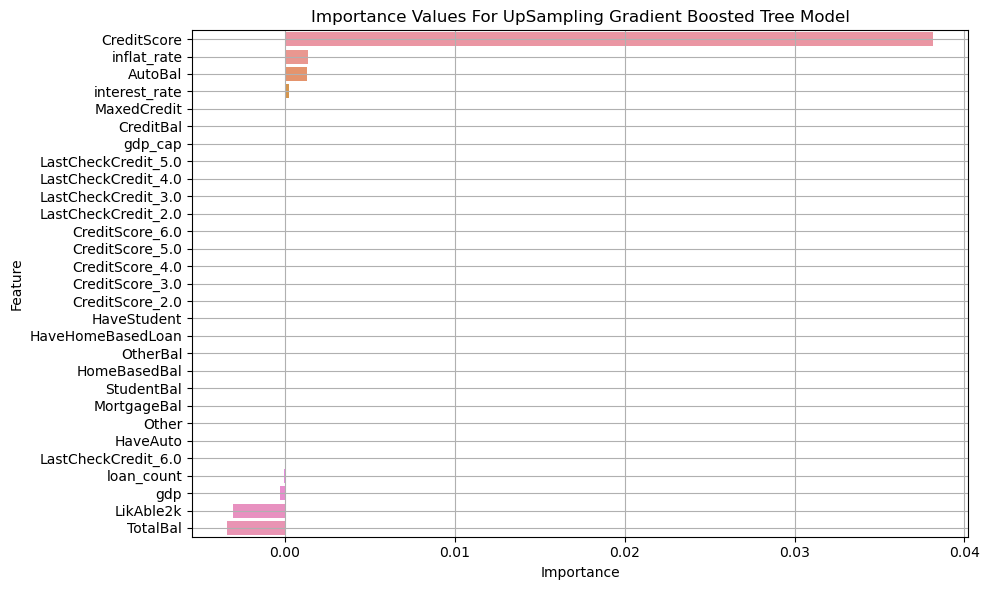

In [116]:
# Make sure your model is already fitted
result = permutation_importance(hbg_down, X_test, y_test, n_repeats=50, random_state=42, n_jobs=-1)
print("\nFeature Coeffiecent Analysis:")
# Build DataFrame
hgbdown_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': result.importances_mean
}).sort_values('Importance', ascending=False)

print(hgbdown_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=hgbdown_df)
plt.title('Importance Values For UpSampling Gradient Boosted Tree Model')
plt.tight_layout()
plt.grid(True)